In [1]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import sys
import os

2023-04-11 16:59:17.082090: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-11 16:59:18.827837: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-11 16:59:27.036205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
X_train=np.lib.format.open_memmap('X_train_11.npy', mode='r', dtype='float32')
y_train=np.lib.format.open_memmap('y_train_11.npy', mode='r', dtype='float32')
X_val=np.lib.format.open_memmap('X_val_11.npy', mode='r', dtype='float32')
y_val=np.lib.format.open_memmap('y_val_11.npy', mode='r', dtype='float32')

In [11]:
#using class weights to counter imbalance in data
from sklearn.utils import class_weight
df=pd.DataFrame(y_train)
class_weights=class_weight.compute_class_weight(class_weight='balanced', classes= [0,1] ,y= df[1].to_list())
class_weights=dict(zip([0,1],class_weights))
class_weights
#as there are more enzymes

{0: 1.0838614165267473, 1: 0.9281837999969078}

In [10]:
yy= df[1].to_list()
yy.count(0)

110778

In [19]:
from tensorflow import keras
import tensorflow as tf
keras.backend.clear_session()

In [13]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Concatenate, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(1000, 21, 1))

conv1 = Conv2D(filters=128, kernel_size=(4, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv2 = Conv2D(filters=128, kernel_size=(8, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv3 = Conv2D(filters=128, kernel_size=(16, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
#conv4 = Conv2D(filters=128, kernel_size=(32, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)

pool1 = MaxPooling2D(pool_size=(997, 1))(conv1)
pool2 = MaxPooling2D(pool_size=(993, 1))(conv2)
pool3 = MaxPooling2D(pool_size=(985, 1))(conv3)
#pool4 = MaxPooling2D(pool_size=(969, 1))(conv4)

flatten1 = Flatten()(pool1)
flatten2 = Flatten()(pool2)
flatten3 = Flatten()(pool3)
#flatten4 = Flatten()(pool4)

bn1 = BatchNormalization()(flatten1)
bn2 = BatchNormalization()(flatten2)
bn3 = BatchNormalization()(flatten3)
#bn4 = BatchNormalization()(flatten4)

concat = Concatenate()([bn1, bn2, bn3])

dense1 = Dense(512)(concat)
bn5 = BatchNormalization()(dense1)
act1 = Activation('relu')(bn5)
dropout1= Dropout(0.3)(act1)

dense2 = Dense(512)(dropout1)
bn6 = BatchNormalization()(dense2)
act2 = Activation('relu')(bn6)
dropout2=Dropout(0.3)(act2)

dense3 = Dense(512)(dropout2)
#bn6 = BatchNormalization()(dense3)
#act3 = Activation('relu')(bn6)
#dropout3=Dropout(0.3)(act3)

output_layer = Dense(2, activation='sigmoid')(dropout2)

model = Model(inputs=input_layer, outputs=output_layer)


In [20]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Concatenate, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(1000, 21, 1))

conv1 = Conv2D(filters=128, kernel_size=(4, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv2 = Conv2D(filters=128, kernel_size=(8, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv3 = Conv2D(filters=128, kernel_size=(16, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)

pool1 = MaxPooling2D(pool_size=(997, 1))(conv1)
pool2 = MaxPooling2D(pool_size=(993, 1))(conv2)
pool3 = MaxPooling2D(pool_size=(985, 1))(conv3)

flatten1 = Flatten()(pool1)
flatten2 = Flatten()(pool2)
flatten3 = Flatten()(pool3)

bn1 = BatchNormalization()(flatten1)
bn2 = BatchNormalization()(flatten2)
bn3 = BatchNormalization()(flatten3)

concat = Concatenate()([bn1, bn2, bn3])

dense1 = Dense(512)(concat)
bn4 = BatchNormalization()(dense1)
act1 = Activation('relu')(bn4)
#dropout1= Dropout(0.2)(act1)

dense2 = Dense(512)(act1)
bn5 = BatchNormalization()(dense2)
act2 = Activation('relu')(bn5)
#dropout2=Dropout(0.2)(act2)

output_layer = Dense(2, activation='sigmoid')(act2)

model = Model(inputs=input_layer, outputs=output_layer)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 21, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 997, 1, 128)  10880       ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 993, 1, 128)  21632       ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 985, 1, 128)  43136       ['input_1[0][0]']            

In [22]:
#with batch size mentioned
#with early stopping

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    batch_size=256,
    callbacks=[early_stopping],
    epochs=40)

2023-04-11 17:16:27.048424: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26466720000 exceeds 10% of free system memory.


Epoch 1/40
1231/1231 [==============================] - 540s 436ms/step - loss: 0.3131 - binary_accuracy: 0.8682 - val_loss: 0.2648 - val_binary_accuracy: 0.8918
Epoch 2/40
1231/1231 [==============================] - 421s 342ms/step - loss: 0.2115 - binary_accuracy: 0.9165 - val_loss: 0.2194 - val_binary_accuracy: 0.9125
Epoch 3/40
1231/1231 [==============================] - 435s 354ms/step - loss: 0.1733 - binary_accuracy: 0.9329 - val_loss: 0.2012 - val_binary_accuracy: 0.9235
Epoch 4/40
1231/1231 [==============================] - 437s 355ms/step - loss: 0.1465 - binary_accuracy: 0.9437 - val_loss: 0.1961 - val_binary_accuracy: 0.9255
Epoch 5/40
1231/1231 [==============================] - 437s 355ms/step - loss: 0.1254 - binary_accuracy: 0.9527 - val_loss: 0.1986 - val_binary_accuracy: 0.9262
Epoch 6/40
1231/1231 [==============================] - 437s 355ms/step - loss: 0.1087 - binary_accuracy: 0.9587 - val_loss: 0.2021 - val_binary_accuracy: 0.9254
Epoch 7/40
1231/1231 [======

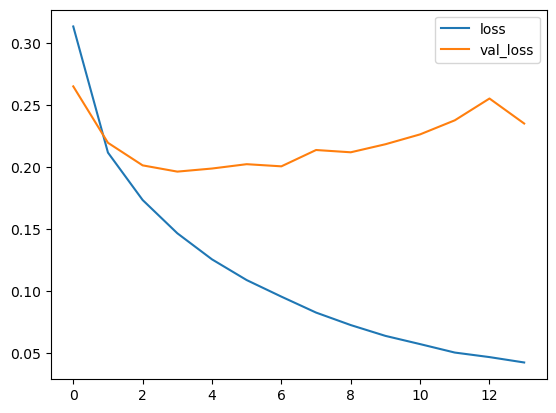

In [24]:
# Show the learning curves
import matplotlib
import matplotlib.pyplot as plt
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.savefig('model_11/loss.png');

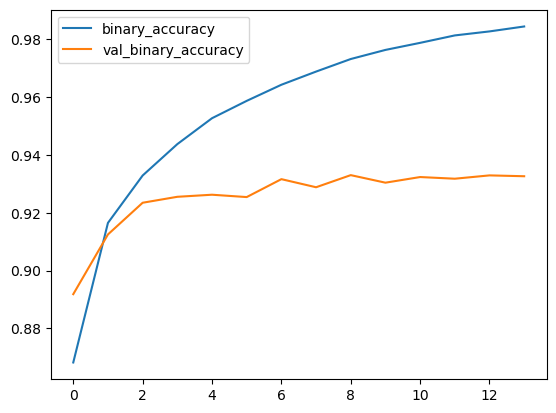

In [25]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()
plt.savefig('model_11/accuracy.png');

In [23]:
os.mkdir('model_11')

In [26]:
#saving history
history_df.to_csv('model_11/model_11.csv')

In [27]:
from keras.models import model_from_json

# Replace 'model' with the name of your trained model
model_name = 'model_11/model_11'

# Save the model architecture as a JSON file
model_json = model.to_json()
with open(model_name + '.json', 'w') as json_file:
    json_file.write(model_json)

# Save the model weights as an H5 file
model.save_weights(model_name + '_weights.h5')

#saving complete model
model.save(model_name + '.h5')

In [21]:
X_train.shape

(240136, 1000, 21, 1)

In [ ]:
np.unique(y_val[:,1], return_counts=True)

In [28]:
from sklearn.metrics import precision_score, recall_score

In [29]:
yy_df=pd.DataFrame(y_val)
yy=yy_df[1].to_list()
yy.count(0)

36414

In [30]:
y_predicted = model.predict(X_val)

2462/2462 [==============================] - 36s 15ms/step


In [37]:
y_predicted_df=pd.DataFrame(y_predicted)
ff=y_predicted_df[1].to_list()


In [38]:
pred_list=[]
for i in ff:
    if i >0.5:
        pred_list.append(1)
    else:
        pred_list.append(0)

In [39]:
prediction=pd.DataFrame(pred_list)
prediction

,0
0,0
1,1
2,0
3,0
4,0
...,...
78765,1
78766,1
78767,1
78768,0


In [40]:
precision = precision_score(yy_df[1], prediction, average='macro')
recall = recall_score(yy_df[1], prediction, average='macro')

In [41]:
precision

0.9255876546841247

In [36]:
recall

0.9243973337012288

In [77]:
#testing their model
from tensorflow.keras.models import load_model

model1=load_model('Binary_class.h5')

In [78]:
y_predicted = model1.predict(X_val)

2462/2462 [==============================] - 38s 15ms/step


In [79]:
y_predicted_df=pd.DataFrame(y_predicted)
ff=y_predicted_df[1].to_list()

In [80]:
pred_list=[]
for i in ff:
    if i >0.5:
        pred_list.append(1)
    else:
        pred_list.append(0)

In [81]:
prediction=pd.DataFrame(pred_list)
prediction

,0
0,0
1,1
2,0
3,0
4,0
...,...
78765,0
78766,1
78767,1
78768,0


In [82]:
precision = precision_score(yy_df[1], prediction)
recall = recall_score(yy_df[1], prediction)

In [83]:
precision

0.7939103703548799

In [84]:
recall

0.8963074889035791

In [85]:
#testing 90% model
from tensorflow.keras.models import model_from_json
with open('model_07.json', 'r') as f:
    model_json = f.read()
model2 = model_from_json(model_json)

model2.load_weights('model_07.h5')

In [86]:
y_predicted = model2.predict(X_val)

2462/2462 [==============================] - 34s 14ms/step


In [87]:
y_predicted_df=pd.DataFrame(y_predicted)
ff=y_predicted_df[1].to_list()

In [88]:
pred_list=[]
for i in ff:
    if i >0.5:
        pred_list.append(1)
    else:
        pred_list.append(0)

In [89]:
prediction=pd.DataFrame(pred_list)
prediction

,0
0,0
1,1
2,0
3,0
4,0
...,...
78765,1
78766,1
78767,1
78768,0


In [90]:
precision = precision_score(yy_df[1], prediction, average='macro')
recall = recall_score(yy_df[1], prediction, average='macro')

In [91]:
precision

0.9495187700249654

In [92]:
recall

0.9495995207016976